In [2]:
from datetime import datetime
import json
from pandas import DataFrame
import requests

In [3]:
base_url = "http://api.firewallcafe.com"

In notebook 12, I discovered that the scraper was incorrectly saving many results. This notebook:
 - finds and deletes the "results soup" search objects in the database (defined as searches with > 100 images)
 - graph the number of images per search over time

Here's the process I used to find those searches. I've rerun this notebook after the fact, so it's now finding 0 occurances of those searches.

In [3]:
terms = requests.get(base_url+"/terms").json()

In [4]:
terms = sorted(terms, key=lambda x: x['search_timestamp'])
terms_dict = {term['search_term_initial']:term['search_timestamp'] for term in terms}

Now we have all unique terms, plus the most recent timestamp that it was searched. Let's look at every 20th search over the last 1000 searches.

In [5]:
terms_list = sorted(list(terms_dict.items()), key=lambda x: x[1], reverse=True)

# for term,ts in terms_list[:1000]:
for i in range(0, 1000, 20):
    term,ts = terms_list[i]
    print(f"{term:35} {datetime.fromtimestamp(int(ts)/1000)}")

ginger                              2021-02-28 16:41:07.794000
lawyer                              2021-02-28 16:35:47.823000
silk road                           2021-02-28 16:23:32.211000
green                               2021-02-28 16:14:01.857000
donald trump                        2021-02-28 16:04:55.837000
1990s                               2021-02-28 16:00:30.333000
doritos                             2020-02-26 18:32:44
butt                                2020-02-26 18:21:07
boobs                               2020-02-26 18:08:41
dogs                                2020-02-26 17:39:11
elections                           2020-02-26 17:28:55
china in pakistan                   2020-02-26 17:14:33
douyin                              2020-02-26 16:27:06
south korea                         2020-02-26 15:26:56
zhao ziyang arrest                  2020-02-26 15:19:37
united states of america            2020-02-26 15:12:02
shanghai church                     2020-02-26 15:00:23
pearl 

In [6]:
len(terms_list)

4167

Okay, that should be plenty far back. It'll take a lot less time to request 1000 than 4000 search object details. We'll keep track of all the search info in a dictionary which maps the search ID to how many images are stored in the DB.

In [7]:
import time

In [8]:
count = 0
searches = {}
limit = 1000
ts = time.time()

for term,_ in terms_list[:limit]:
    r = requests.get(base_url+"/searches/terms?term="+term)
    if r.status_code >= 400:
        print("failed on term", term)
        continue
    j = r.json()
    for search in j:
        searches[search['search_id']] = len(search['image_hrefs'])
    if count % 10 == 9:
        print(f"{count:3}: {term:35}  {len(j):4} {round(time.time()-ts,1)} seconds")
        ts = time.time()
    count += 1

  9: car trip                                9 6.6 seconds
 19: court                                   9 6.5 seconds
 29: cowboy                                  9 6.2 seconds
 39: south china sea                        17 6.9 seconds
 49: chinese new year                       10 6.9 seconds
 59: new york times                          9 6.9 seconds
 69: tiananmen square                       43 7.6 seconds
 79: obama                                  17 7.1 seconds
 89: Critical                                9 8.0 seconds
 99: Communist                               9 7.2 seconds
failed on term 
109: red square                              1 7.7 seconds
119: doritos                                 1 7.1 seconds
129: james madison                           1 6.5 seconds
139: butt                                    2 6.8 seconds
149: panda                                   3 7.1 seconds
159: boobs                                   1 6.9 seconds
169: meth                               

In [9]:
from pandas import Series, read_csv

In [10]:
import pickle
with open('searches.pkl', 'wb') as f:
    f.write(pickle.dumps(searches))
    
with open('searches.pkl', 'rb') as f:
    searches = pickle.load(f)

In [11]:
s = Series(searches)

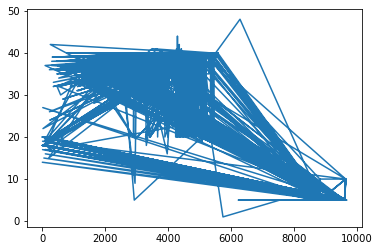

In [12]:
s.plot(kind='line')

It seems that we really only need to be looking at searches with IDs above 6000, so we should have all the offending searches. And these will all be from the automatic scraper, which means deleting them won't lose anything valuable.

In [16]:
import ipyplot

In [17]:
def delete_search(search_id):
    # get all images for this search
    r = requests.get(base_url+'/images/search_id/'+str(search_id))
    imgs = r.json()
    
#     ipyplot.plot_images([img['image_href'] for img in imgs][:8], img_width=75)

    # delete the image objects
    print("deleting", len(imgs), "images")
    failures = []
    for img in imgs:
        r = requests.post(base_url+'/deleteImage', data={'image_id':img['image_id']})
        if r.status_code >= 400:
            print("could not delete image", img['image_id'], r)
            failures.append(img['image_id'])
                        
    # delete the search object
    r = requests.post(base_url+'/deleteSearch', data={'search_id':search_id})
    print("/deleteSearch:", r)
    if r.status_code >= 400:
        print(r.json())
        return 
    
    return failures

In [15]:
print("deleting", len(s[s>100]), "searches with associated images")
failures = []
count = 0
total = len(s[s>100])
for ix,val in s[s>100].items():
    ts = time.time()
    # double check the term and images to allow sanity checking that we're deleting only the ones we want
    r = requests.get(base_url+'/searches/search_id/'+str(ix))
    j = r.json()
    if len(j) == 0:
        continue
    print("delete search", ix, r.json()[0]['search_term_initial'])
    
    failures += delete_search(ix)
    # check that it was actully deleted
    r = requests.get(base_url+'/searches/search_id/'+str(ix))
    count += 1
    if r.status_code > 300:
        print("failed")
    else:
        print("successful", r, round(time.time()-ts, 1), "seconds,", count, "of", total)

deleting 0 searches with associated images


## Delete searches in ID range

This is for if we have a series of test searches that we want to scrub from the DB. First we need to find the range of the search IDs, then delete each one and its images.

In [4]:
r = requests.get(f'{base_url}/searches?page_size=500')
j = r.json()

In [5]:
j[0]

{'search_id': 10673,
 'search_timestamp': '1614973988872',
 'search_location': 'automated_scraper',
 'search_ip_address': '192.168.0.1',
 'search_client_name': 'automated_scraper',
 'search_engine_initial': None,
 'search_engine_translation': None,
 'search_term_initial': 'asparagus',
 'search_term_initial_language_code': 'EN',
 'search_term_initial_language_confidence': '1.0',
 'search_term_initial_language_alternate_code': None,
 'search_term_translation': 'test',
 'search_term_translation_language_code': 'zh-CN',
 'search_term_status_banned': False,
 'search_term_status_sensitive': False,
 'search_schema_initial': None,
 'wordpress_search_term_popularity': None,
 'wordpress_copyright_takedown': None,
 'wordpress_unflattened': None,
 'wordpress_regular_post_id': None,
 'wordpress_search_result_post_id': None,
 'wordpress_search_result_post_slug': None}

In [13]:
for search in j:
    print(f"{search['search_id']:10}   {search['search_term_initial']:50} {datetime.fromtimestamp(int(search['search_timestamp'])/1000)}")

     10673   asparagus                                          2021-03-05 11:53:08.872000
     10672   asparagus                                          2021-03-05 11:47:28.535000
     10671   zyKang                                             2021-03-04 17:25:06.364000
     10670   Zhou Enlai                                         2021-03-04 17:24:53.616000
     10669   Yuyao  protesters                                  2021-03-04 17:24:42.460000
     10668   Xinjiang violence                                  2021-03-04 17:24:30.801000
     10667   xinjiang terrorism                                 2021-03-04 17:24:19.209000
     10666   Xinjiang  control                                  2021-03-04 17:24:06.554000
     10665   Xi Jinping  assassinate                            2021-03-04 17:23:55.433000
     10664   Xi  fake news                                      2021-03-04 17:23:44.388000
     10663   Xi  Deal                                           2021-03-04 17:23:32.915000

There are some test searches we want to delete. ~~There was also a one-time bug with the Baidu results, and we just want to delete those.~~ Actually, it turns out that the one-time bug stored both Baidu and Google results together, so we'll have to delete those searches entirely :(

Delete everything:
 - 10261 to 10407
 
Delete Baidu searches:
 - 10408 to 10673

In [14]:
r = requests.get(base_url+'/images/search_id/'+str(10398))
imgs = r.json()
imgs[0]

{'image_id': 613907,
 'image_search_engine': 'google',
 'image_href': 'https://firewall-test.nyc3.digitaloceanspaces.com/images/hashed/86cb7b1489ded069.jpg',
 'image_rank': '8',
 'image_mime_type': None,
 'wordpress_attachment_post_id': None,
 'wordpress_attachment_file_path': None}

In [25]:
def delete_images(search_id, search_engines=['baidu', 'google']):
    # get all images for this search
    r = requests.get(base_url+'/images/search_id/'+str(search_id))
    imgs = r.json()
    
    print("deleting", len(imgs), "images from", " and ".join(search_engines))
    failures = []
    deleted = 0
    for img in imgs:
        if img['image_search_engine'] not in search_engines:
            continue
        r = requests.post(base_url+'/deleteImage', data={'image_id':img['image_id']})
        if r.status_code >= 400:
            print("could not delete image", img['image_id'], r)
            failures.append(img['image_id'])
        else:
            deleted += 1
    print(f"deleted {deleted} of {len(imgs)}")

Delete everything:

In [26]:
# for search_id in range(10261, 10407+1):
#     delete_search(search_id)

~~Delete just Baidu~~ Also delete everything:

In [28]:
for search_id in range(10408, 10673+1):
    delete_search(search_id)

deleting 1 images
/deleteSearch: <Response [201]>
deleting 1 images
/deleteSearch: <Response [201]>
deleting 18 images
/deleteSearch: <Response [201]>
deleting 31 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: <Response [201]>
deleting 40 images
/deleteSearch: